In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
from __future__ import print_function

import argparse
import os
import zipfile
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
print('Random Seed:', manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed: 999


Dataset Celeba from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

save 'img_align_celeba.zip' on your data drive first

In [71]:
zip_path = '/content/drive/MyDrive/images/img_align_celeba.zip'

In [72]:
# make directory
if not os.path.exists('/content/celeba'):
    os.mkdir('/content/celeba')
    zipfile.ZipFile(zip_path, 'r').extractall('/content/celeba')

In [93]:
dataroot = '/content/celeba'
workers = 2
batch_size = 128
num_epochs = 3
lr = 5e-4
ngpu = 1

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3.
nc = 3

# Size of z latent vector(i.e size of generator input)
nz = 100

# size of feature maps in generator
ngf = 128

# size of feature maps in discriminator
ndf = 128

# bet1 hyperparameter for Adam optimizers
beta1 = 0.5

In [94]:
transform = transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

In [95]:
dataset = dset.ImageFolder(root = dataroot,
                           transform = transform
                           )
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size = batch_size,
                                         shuffle = True,
                                         num_workers = workers,
                                         )

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() and ngpu>0 else 'cpu')
print(device)

cuda


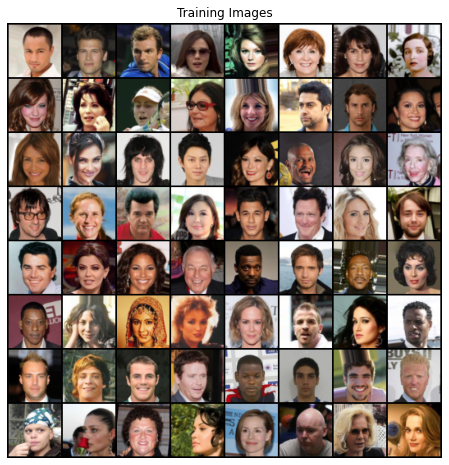

In [97]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
img_grid = vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu()
np_img_grid = np.transpose(img_grid, (1,2,0))

plt.axis('off')
plt.title('Training Images')
plt.imshow(np_img_grid)

# Implementation

## Weight Initialization

In [98]:
# From the DCGAN paper, the authors specify that all model weights shall be randomly initailized from a Normal Dist
# with mean = 0, std = 0.02.

# This function takes an initialized model as input
# and reinitializes all <convolutional>, <convolutional-transpose>, and <batch normalization> layers.

# This function is applied to the models immediately after initialization.

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [99]:
# Generator G is desined to map the latent space vector (z) to data-space.
# Since Our data are images, mapping (z) to data-space means creating a RGB image with the same size as the train images(3x64x64)
# In practice, this is accomplished through 'a series of strided two dimensional convolutional transpose layers',
# each paired with a 2d batch norm layer and a relu activation.

# The output of generator is fed through a tanh function to return it to the input data range of [-1, 1]

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*8,
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [100]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type =='cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialization all weights
# to mean = 0.0, std = 0.02
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [101]:
# Discriminator is a binary classification nerwork that takes an image as input and outputs a scalar probability
# that the input image is real(as opposed to fake).

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, out_channels=ndf,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, out_channels=ndf*2,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf*2, out_channels=ndf*4,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf*4, out_channels=ndf*8,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf*8, out_channels=1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        out = self.main(x)
        return out

In [102]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean = 0, std = 0.02
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Sigmoid()
  )
)


# Loss and Optimizer

In [103]:
# Loss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
print('fixed_noise shape : ', fixed_noise.shape)


# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise shape :  torch.Size([64, 100, 1, 1])


# Train the model

In [ ]:
from torch._C import dtype
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Starting Training Loop...')
# For each epoch
for epoch in range(1, num_epochs+1):
    # For each batch in the dataloader
    for batch_idx, data in enumerate(dataloader, 0):

        ############################################################
        # (1) Update D network: maximize log(D(x)) + log(1-D(G(z)))#
        ############################################################
        # Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) # batch_size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ##############################################
        # (2) Update G network: maximize log(D(G(z)))#
        ##############################################
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another fforward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if batch_idx%50 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_idx}/{len(dataloader)}], Loss_D:{errD.item():.4f}, Loss_G:{errG.item():.4f}, D(x):{D_x:.4f}, D(G(z)):{D_G_z1:.4f}/{D_G_z2:.4f}')
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is ding by saving G's output on fixed_noise
        if (iters%500 == 0) or ((epoch == num_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

Starting Training Loop...
Epoch [1/3], Step [0/1583], Loss_D:1.3928, Loss_G:0.9885, D(x):0.5068, D(G(z)):0.5097/0.3727
Epoch [1/3], Step [50/1583], Loss_D:0.9529, Loss_G:1.1809, D(x):0.6334, D(G(z)):0.2365/0.3074
Epoch [1/3], Step [100/1583], Loss_D:0.7470, Loss_G:1.6544, D(x):0.7502, D(G(z)):0.3157/0.1989
Epoch [1/3], Step [150/1583], Loss_D:0.9561, Loss_G:1.7602, D(x):0.6410, D(G(z)):0.3498/0.1881
Epoch [1/3], Step [200/1583], Loss_D:0.9764, Loss_G:1.1375, D(x):0.6291, D(G(z)):0.3693/0.3339
Epoch [1/3], Step [250/1583], Loss_D:0.9938, Loss_G:1.7022, D(x):0.6925, D(G(z)):0.4229/0.2076
Epoch [1/3], Step [300/1583], Loss_D:0.8898, Loss_G:1.7893, D(x):0.6921, D(G(z)):0.3391/0.1864
Epoch [1/3], Step [350/1583], Loss_D:0.9698, Loss_G:1.6735, D(x):0.6724, D(G(z)):0.3648/0.2002
Epoch [1/3], Step [400/1583], Loss_D:1.0620, Loss_G:3.8702, D(x):0.7894, D(G(z)):0.5266/0.0246
Epoch [1/3], Step [450/1583], Loss_D:0.8166, Loss_G:2.4432, D(x):0.6900, D(G(z)):0.2698/0.0953
Epoch [1/3], Step [500/1583

# Results

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Real images vs Fake images

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
# Plot the real images
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1,2,0)))

# Plot the fake images
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()